In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

###  ToDo:
* zrobić coś w stylu inital_concept.jpg
* skupić się na razie na portfelu ETF
* Wykres NetWorth to można zrobić coś w stylu, że jest interwał miesięczny, poczynając od miesiąca z daty pierwszej transakcji kupna etfa i potem już co miesiąc, gdzie po prostu biorę co miesiąc sumę wszytskich aktywów i przemnażam przez ich cenę z tego okresu (data końca miesiąca albo średnia miesięczna cena dla każdego tickera), co daje mi jedną obserwację na wykresie
    * z tego w sumie może powstać wykres gdzie jedna linia jest mnożona przez cenę i pokazuje realną zmienność portfela, a druga linia jest tylko wpłatami kapitału, czyli za ile coś kupiłem, to by fajnie pokazywało jaka jest relacja wpłacanego kapitału do realnej wartości portfela
    * można by też wtedy dodać kolory, że jak linia wartości jest wyżej niż wpłacania, to zysk - zielony, a jak spadnie poniżej wpłacony kapitał, to strata - czerwony
* Wykres Allocations zrobić analogiczny do kołowych wykresów u mnie w excelu, ale z jakąś agregacją etfów z danego typu np. DTLA i IDTL wyświetlane jako jedna pozycja podpisana "US tre 20+". Dalsza granulacja na konta i poszczególne etfy może być w dalszym podsumowaniu (może osobne strony dla każdego brokera czy coś, chociaż nie wiem czy jest sens)
* Dodać w zakładce Holdings kolumnę z info o koncie na jakim jest kupiony dany ticker

In [106]:
# to jest tylko ilość kupiona na dany moment, a potrzeba mi cyklicznego podumowania ilości każdego assetu i cen

# żeby to wyżej działało jak trzeba, musi być tabelka z historią portfela, gdzie sumowane aktywa będą miały obliczane wartości na daną datę (np. koniec kwartału)

# napisać algorytm który sprawdza jakie są assety w transakcjach i przelicza dla nich historię, jak się coś pojawi to po tej dacie dodawany jest do cyklicznego generowania historii

# na koniec każdego kwartału jest brany kurs walut i aktywów i obliczana jest wartość bazując na amount

# ogarnąć interaktywne ploty współpracujące z dashem (pewnie plotly) 
# https://plotly.com/python/bar-charts/

### Data preparation

In [186]:
df_raw = pd.read_excel('data/transactions.xlsx')

In [187]:
df = df_raw.copy()

In [188]:
df.head()

,account,date,ticker,currency,asset_type,transaction_type,amount,price,commision,pln_exr,total_pln
0,treasury_bonds_pl,2020-02-08,COI,PLN,bonds,buy,600.0000,100.0000,0.0000,1.0000,60000.0000
1,treasury_bonds_pl,2023-09-01,TOS,PLN,bonds,buy,100.0000,100.0000,0.0000,1.0000,10000.0000
2,treasury_bonds_pl,2023-10-02,EDO,PLN,bonds,buy,10.0000,100.0000,0.0000,1.0000,1000.0000
3,treasury_bonds_pl,2023-11-09,EDO,PLN,bonds,buy,10.0000,100.0000,0.0000,1.0000,1000.0000
4,ikze,2023-11-21,EDO,PLN,bonds,buy,83.0000,100.0000,0.0000,1.0000,8300.0000


In [121]:
df.account.unique()

array(['treasury_bonds_pl', 'ikze', 'xtb', 'ike'], dtype=object)

In [122]:
df_group = df[['account', 'ticker', 'asset_type', 'amount','total_pln']]

In [123]:
df_group['quarter'] = df['date'].dt.year.astype(str) + "Q" + df['date'].dt.quarter.astype(str)

In [124]:
df_group.groupby(['account', 'asset_type']).sum()['total_pln'].reset_index()

,account,asset_type,total_pln
0,ike,etf_bond,12303.8458
1,ike,etf_stock,4239.4353
2,ikze,bonds,8300.0000
3,treasury_bonds_pl,bonds,72000.0000
4,xtb,etf_bond,3299.8717
5,xtb,etf_stock,10796.0439
6,xtb,stock_pl,3217.4400


In [125]:
df_group.groupby(['asset_type', 'quarter']).sum()['total_pln'].reset_index()

,asset_type,quarter,total_pln
0,bonds,2020Q1,60000.0000
1,bonds,2023Q3,10000.0000
2,bonds,2023Q4,10300.0000
3,etf_bond,2023Q3,1375.4781
4,etf_bond,2023Q4,9725.5558
5,etf_bond,2024Q1,4502.6836
6,etf_stock,2023Q3,5194.5187
7,etf_stock,2023Q4,5601.5253
8,etf_stock,2024Q1,4239.4353
9,stock_pl,2023Q1,1858.3000


In [126]:
df_pivot = pd.pivot_table(df_group, values='total_pln', index='quarter', columns='asset_type', aggfunc='sum', fill_value=0)

In [127]:
df_pivot.columns

Index(['bonds', 'etf_bond', 'etf_stock', 'stock_pl'], dtype='object', name='asset_type')

In [128]:
df_pivot

asset_type,bonds,etf_bond,etf_stock,stock_pl
quarter,,,,
2020Q1,60000,0.0000,0.0000,0.0000
2023Q1,0,0.0000,0.0000,1858.3000
2023Q2,0,0.0000,0.0000,30.9000
2023Q3,10000,1375.4781,5194.5187,269.5900
2023Q4,10300,9725.5558,5601.5253,1058.6500
2024Q1,0,4502.6836,4239.4353,0.0000


### Plots by quarter

<Axes: title={'center': 'Buys by quarter'}, ylabel='quarter'>

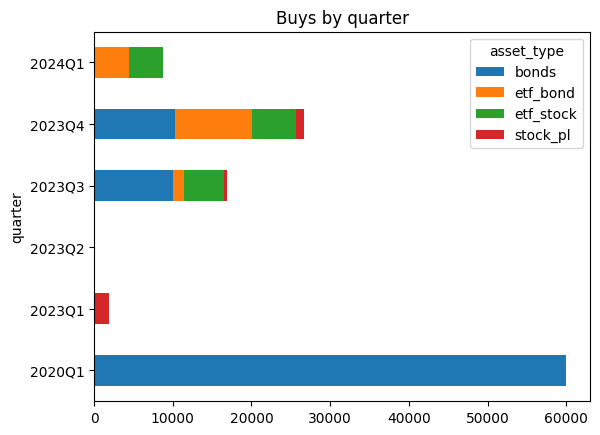

In [29]:
df_pivot.plot( 
    # x = 'quarter', 
    kind = 'barh', 
    stacked = True, 
    title = 'Buys by quarter', 
    mark_right = True) 

In [30]:
for i in range(1, len(df_pivot)):
    r = df_pivot.index[i]
    print(r)
    r1 = df_pivot.index[i-1]
    for c in df_pivot.columns:
        if df_pivot.loc[r, c] == 0:
            df_pivot.loc[r, c] = df_pivot.loc[r1, c]
        if df_pivot.loc[r, c] != df_pivot.loc[r1, c]:
            df_pivot.loc[r, c] = df_pivot.loc[r, c] + df_pivot.loc[r1, c]

2023Q1
2023Q2
2023Q3
2023Q4
2024Q1


In [31]:
df_pivot

asset_type,bonds,etf_bond,etf_stock,stock_pl
quarter,,,,
2020Q1,60000,0.0000,0.0000,0.0000
2023Q1,60000,0.0000,0.0000,1858.3000
2023Q2,60000,0.0000,0.0000,1889.2000
2023Q3,70000,1375.4781,5194.5187,2158.7900
2023Q4,80300,11101.0339,10796.0439,3217.4400
2024Q1,80300,15603.7175,15035.4793,3217.4400


In [41]:
df_prc = df_pivot.div(df_pivot.sum(axis=1), axis=0).reset_index()

In [42]:
df_prc

asset_type,quarter,bonds,etf_bond,etf_stock,stock_pl
0,2020Q1,1.0000,0.0000,0.0000,0.0000
1,2023Q1,0.9700,0.0000,0.0000,0.0300
2,2023Q2,0.9695,0.0000,0.0000,0.0305
3,2023Q3,0.8891,0.0175,0.0660,0.0274
4,2023Q4,0.7618,0.1053,0.1024,0.0305
5,2024Q1,0.7034,0.1367,0.1317,0.0282


<Axes: title={'center': 'Portfolio composition in time'}>

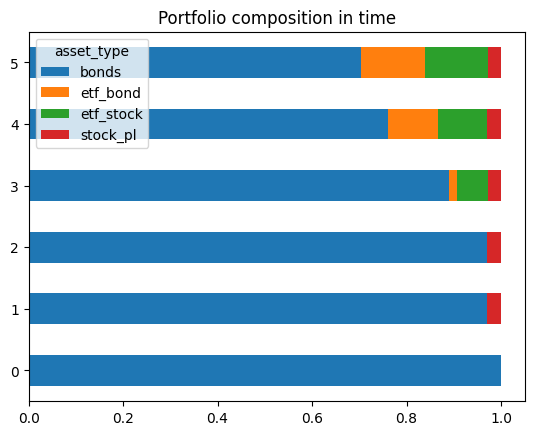

In [51]:
df_prc.plot( 
    kind = 'barh', 
    stacked = True, 
    title = 'Portfolio composition in time', 
    # mark_right = True
)

In [47]:
df_plot = pd.melt(df_prc, id_vars='quarter', value_vars=list(df_prc.columns[1:]), var_name='asset_type', value_name='total_pln')

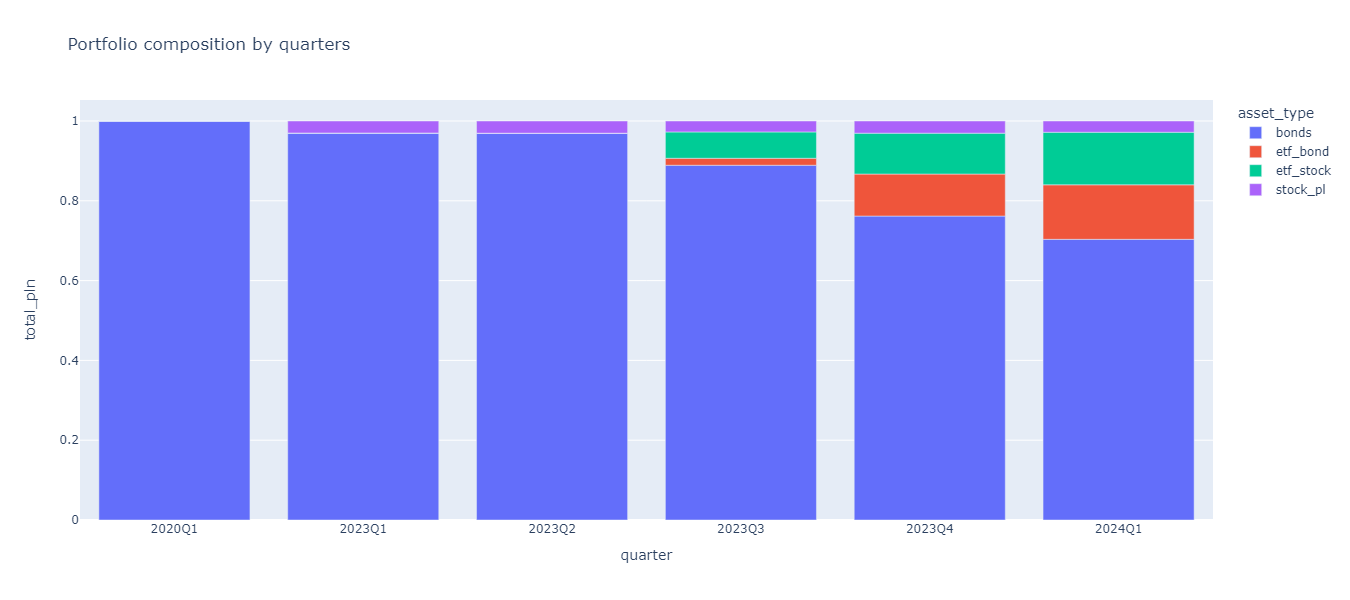

In [70]:
fig = px.bar(df_plot, x="quarter", y="total_pln", color="asset_type", title="Portfolio composition by quarters")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    # paper_bgcolor="LightSteelBlue",
)

fig.show()

### Holdings table

In [131]:
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

In [204]:
def holdings_table(tickers):
    holdings = pd.DataFrame(columns=['ticker', 'currency', 'asset_type', 'amount', 'avg_buy_price', 'current_price', 'return_pct'])
    for t in tickers:
        print(t)
        ticker = df[(df['ticker'] == t) & (df['transaction_type'] == 'buy')]
        ticker['total_cur'] = ticker['amount'] * ticker['price']
        ticker_agg = ticker[['ticker', 'currency', 'asset_type', 'amount', 'price']].groupby(['ticker', 'currency', 'asset_type']).sum().reset_index()
        ticker_agg.loc[0, 'price'] = ticker['total_cur'].sum() / ticker['amount'].sum() 
        ticker_agg = ticker_agg.rename(columns={'price': 'avg_buy_price'})
        ticker_agg['current_price'] = get_current_price(t)
        ticker_agg['return_pct'] = (ticker_agg['current_price'] - ticker_agg['avg_buy_price']) / ticker_agg['avg_buy_price']
        holdings = pd.concat([holdings, ticker_agg])
    holdings = holdings.reset_index(drop=True)
    return holdings

In [233]:
def portfolio_return(holdings):
    current = (holdings['current_price'] * holdings['amount']).sum()
    initial = (holdings['avg_buy_price'] * holdings['amount']).sum()
    return round(((current - initial) / initial), 4)

In [205]:
holdings_etfs = holdings_table(df[df['asset_type'].str.contains('etf')]['ticker'].unique())

EIMI.L
DTLA.L
SWRD.L
IDTL.L
VWRL.AS


In [206]:
holdings_etfs

,ticker,currency,asset_type,amount,avg_buy_price,current_price,return_pct
0,EIMI.L,USD,etf_stock,17.0000,29.9565,30.5800,0.0208
1,DTLA.L,USD,etf_bond,186.0000,4.1976,4.6380,0.1049
2,SWRD.L,USD,etf_stock,70.0000,30.1476,33.8300,0.1221
3,IDTL.L,USD,etf_bond,886.0000,3.4829,3.5510,0.0195
4,VWRL.AS,EUR,etf_stock,9.0000,107.8600,112.1200,0.0395


In [236]:
print("ETF portfolio return: ", portfolio_return(holdings_etfs))

ETF portfolio return:  0.0602


In [218]:
# woodpecker nie jest na zagranicznych listach, więc nie ma tickera
bought_pl = df[df['asset_type'].str.contains('pl')]['ticker'].unique()
sold_pl = df[(df['asset_type'].str.contains('pl')) & (df['transaction_type'] == 'sell')]['ticker'].unique()
holdings_pl = holdings_table(np.setdiff1d(bought_pl, np.append(sold_pl, 'WPR.WA')))

1AT.WA
ALL.WA
APR.WA
ASE.WA
BCS.WA
CDR.WA
VOT.WA
WTN.WA


In [219]:
holdings_pl

,ticker,currency,asset_type,amount,avg_buy_price,current_price,return_pct
0,1AT.WA,PLN,stock_pl,4.0000,36.0000,59.4000,0.6500
1,ALL.WA,PLN,stock_pl,28.0000,19.2554,19.7000,0.0231
2,APR.WA,PLN,stock_pl,17.0000,16.3706,26.6000,0.6249
3,ASE.WA,PLN,stock_pl,6.0000,47.7667,56.8000,0.1891
4,BCS.WA,PLN,stock_pl,4.0000,46.5750,22.8000,-0.5105
5,CDR.WA,PLN,stock_pl,1.0000,134.7000,104.2000,-0.2264
6,VOT.WA,PLN,stock_pl,13.0000,47.1308,47.0000,-0.0028
7,WTN.WA,PLN,stock_pl,24.0000,26.6792,29.4000,0.1020


In [235]:
print("PL portfolio return: ", portfolio_return(holdings_pl))

PL portfolio return:  0.0964
